In [1]:
import pandas as pd
import numpy as np
import h5py
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm
import astropy
import matplotlib.pyplot as plt
import seaborn as sns
import galpy
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential, ICRS, Galactic, CylindricalRepresentation, CylindricalDifferential
from matplotlib.colors import Normalize
from galpy.util.coords import lbd_to_XYZ, XYZ_to_galcencyl
import warnings
pd.set_option('display.max_columns', None)

In [2]:
table = Table.read("../data/vis_main_filtered.fits", format='fits') # filtered or non filtered....

# Convert to a pandas DataFrame
df_vis = table.to_pandas()


In [3]:
df_vis.head()

,aom_xp,b,bp_rp,dec,e_aom_xp,e_logg_xp,e_moh_xp,e_teff_xp,fake_MG,l,logg_xp,moh_xp,parallax,parallax_error,phot_bp_mean_mag,phot_bp_rp_excess_factor,phot_g_mean_mag,phot_rp_mean_mag,pmdec,pmdec_error,pmra,pmra_error,ra,radial_velocity,radial_velocity_error,ruwe,snr_bp,snr_rp,source_id,teff_xp,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,parallax_over_error,MW1,G,GBP,W1,W2,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag,R,Z,R_gal,phi_gal,Z_gal,v_phi,v_R,v_Z,rpgeo_error,rpgeo,v_R_uncertainty,v_phi_uncertainty,v_Z_uncertainty,E(B-V),fpu
0,0.0189,-48.572035,1.154534,0.335043,0.0222,0.1309,0.0717,53.5303,158.232347,176.739184,2.8993,-0.1789,1.407660,0.018947,10.750277,1.230957,10.253987,9.595743,-1.412098,0.016528,-0.711280,0.017718,45.136038,-0.738894,0.316921,1.036041,339.585517,704.910156,15741055975040,5096.609863,8.152,8.198,-0.144,5065.8,2.993,74.293738,-1.105511,10.253987,10.750277,8.152,8.198,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,b'10033',8.582006,-0.522061,470.485258,0.055731,-520.632142,243.095762,-14.428048,4.529900,9.436554,696.278320,0.239913,0.058891,0.270113,0.104689,0.013460
1,0.1512,-48.171322,1.409290,0.736093,0.0502,0.1197,0.0759,44.4781,63.236201,176.483565,1.7891,-0.4944,0.500272,0.020692,11.150994,1.254608,10.508797,9.741704,1.594356,0.022822,3.309832,0.022959,45.305053,41.607450,1.323430,1.349013,254.753264,849.925883,66627828480768,4480.451172,7.891,7.964,-0.401,4499.0,1.916,24.176686,-3.612968,10.508797,11.150994,7.891,7.964,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,b'10033',9.375831,-1.403210,1268.325930,0.060773,-1399.358389,237.364263,42.346437,-2.860027,68.673585,1883.143550,1.348012,0.424627,1.318067,0.093026,0.041362
2,0.0036,-48.607026,1.189063,0.561503,0.0080,0.0742,0.0333,30.6331,293.932164,176.209301,3.0343,0.0696,2.177522,0.016049,11.169669,1.230755,10.651423,9.980606,-12.678339,0.013950,-4.869755,0.015797,44.866246,-32.461674,0.205614,1.018742,330.678438,796.410471,82467667849472,4890.509277,8.496,8.558,0.114,4938.3,3.203,135.681722,0.185813,10.651423,11.169669,8.496,8.558,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,b'10033',8.420638,-0.339539,308.483632,0.064184,-338.602406,230.329127,-51.045366,13.944756,3.087768,452.602692,0.187703,0.100095,0.202024,0.086075,0.007370
3,0.2962,-48.727781,1.131072,0.689953,0.0328,0.1724,0.0808,59.5872,356.979240,175.755174,2.9970,-0.5701,0.485402,0.024241,14.816144,1.228919,14.332705,13.685072,-1.599436,0.021891,3.539184,0.027864,44.569524,91.295900,4.830661,1.176748,197.334453,241.162594,101193725229056,4889.291016,12.220,12.275,-0.478,4980.2,3.319,20.024124,0.650509,14.332705,14.816144,12.220,12.275,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,b'10033',9.351665,-1.404413,1245.041147,0.073347,-1400.635394,217.472712,62.829005,-53.068842,74.445250,1868.603880,3.090188,1.342318,3.503142,0.078062,0.049940
4,0.0726,-48.328584,1.328486,0.955080,0.0245,0.0762,0.0429,27.8866,143.555092,175.789759,2.5074,-0.1392,0.820288,0.017479,11.810220,1.246487,11.215262,10.481733,-0.291235,0.015982,3.382907,0.017619,44.868872,1.959265,0.328298,1.087555,312.296155,668.643675,130399502833792,4682.432129,8.728,8.815,-0.159,4643.6,2.398,46.929778,-1.702169,11.215262,11.810220,8.728,8.815,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,b'10033',8.903067,-0.879697,793.842786,0.072479,-877.288236,231.337541,1.866465,13.969564,23.551575,1177.687260,0.345464,0.290456,0.293789,0.077163,0.021308


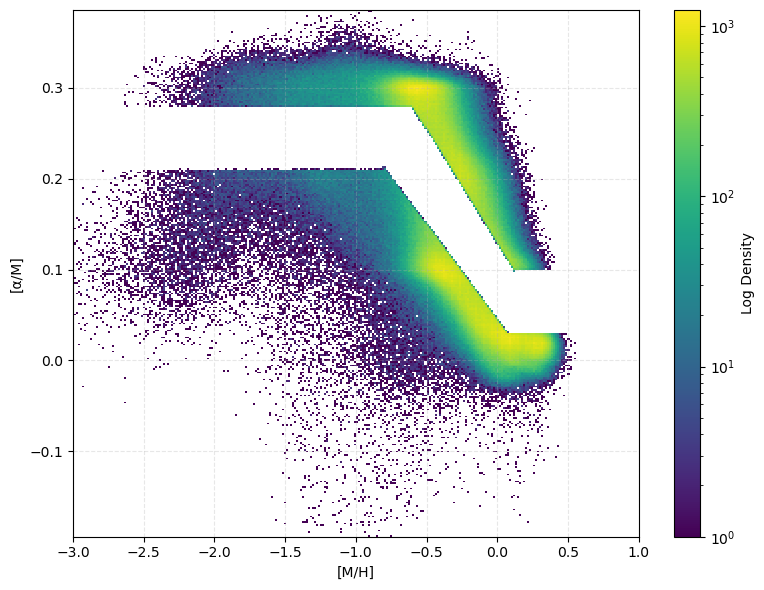

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Rename for clarity
alpha = df_vis['aom_xp']
metallicity = df_vis['mh_xgboost']

# Filter out NaNs
valid = (~alpha.isna()) & (~metallicity.isna())
alpha = alpha[valid]
metallicity = metallicity[valid]

# Define masks

# High-α region
high_alpha_mask = (
    ((metallicity < -0.6) & (alpha > 0.28)) |
    ((metallicity >= -0.6) & (metallicity <= 0.125) & (alpha > (-0.25 * metallicity + 0.13))) |
    ((metallicity > 0.125) & (alpha > 0.1))
)

# Low-α region
low_alpha_mask = (
    ((metallicity < -0.8) & (alpha < 0.21)) |
    ((metallicity >= -0.8) & (metallicity <= 0.07) & (alpha < (-0.21 * metallicity + 0.045))) |
    ((metallicity > 0.07) & (alpha < 0.03))
)

# Purple band = stars that are in neither high-α nor low-α
purple_band_mask = ~(high_alpha_mask | low_alpha_mask)

# Filter out purple band
alpha_filtered = alpha[~purple_band_mask]
metallicity_filtered = metallicity[~purple_band_mask]

# Plotting
plt.figure(figsize=(8, 6))
plt.hist2d(metallicity_filtered, alpha_filtered, bins=300, norm='log', cmap='viridis')
plt.xlim(-3, 1)
plt.colorbar(label='Log Density')
plt.xlabel('[M/H]')
plt.ylabel('[α/M]')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig(f'../figures/alpha_vs_metalicity.png', dpi=300, bbox_inches='tight')
plt.show()


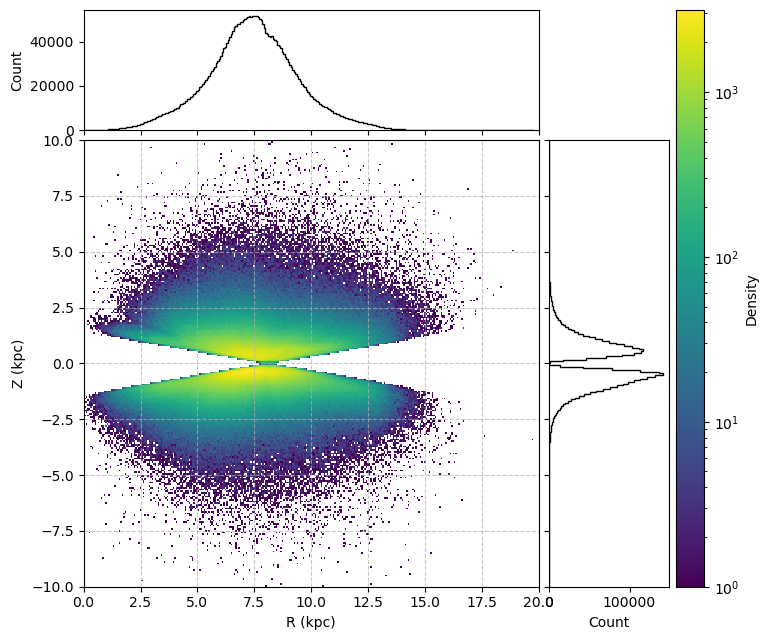

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_rz_distribution(df, r_column='R', z_column='Z', bins=100):
    """
    Plot Galactocentric radius (R) vs height (Z) distribution with 1D histograms on axes.
    
    Parameters:
    - df: DataFrame containing the data.
    - r_column: Name of the column for Galactocentric radius.
    - z_column: Name of the column for height above the Galactic plane.
    - bins: Number of bins for the histograms.
    """
    R = df[r_column]
    Z = df[z_column]

    # Define figure and grid
    fig, ax_scatter = plt.subplots(figsize=(8, 6.5))
    
    # Create divider for scatter plot and histograms
    divider = make_axes_locatable(ax_scatter)
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax_scatter)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax_scatter)

    # Scatter plot with 2D histogram
    h = ax_scatter.hist2d(
        R, Z, bins=bins, norm=LogNorm(), cmap="viridis", cmin=1
    )
    cbar = fig.colorbar(h[3], ax=ax_scatter, pad=0.01)
    cbar.set_label("Density")
    
    ax_scatter.set_xlabel("R (kpc)")
    ax_scatter.set_ylabel("Z (kpc)")
    ax_scatter.set_xlim(0, 20)
    ax_scatter.set_ylim(-10, 10)
    ax_scatter.grid(True, linestyle="--", alpha=0.7)

    # 1D histograms
    ax_histx.hist(R, bins=bins, histtype="step", color="black")
    ax_histy.hist(Z, bins=bins, histtype="step", orientation="horizontal", color="black")

    # Remove ticks on histograms for cleaner appearance
    ax_histx.tick_params(labelbottom=False)
    ax_histy.tick_params(labelleft=False)
    
    ax_histx.set_ylabel("Count")
    ax_histy.set_xlabel("Count")

    # Final adjustments
    fig.tight_layout()
    plt.savefig('../figures/vis_ZR_distribution.png', dpi=300)
    plt.show()

# Example usage
plot_rz_distribution(df_vis, r_column='R', z_column='Z', bins=300)


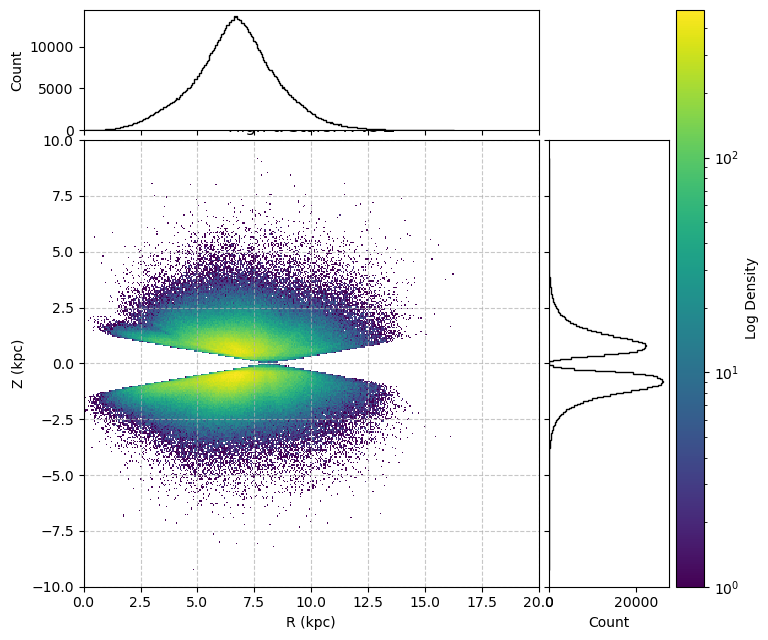

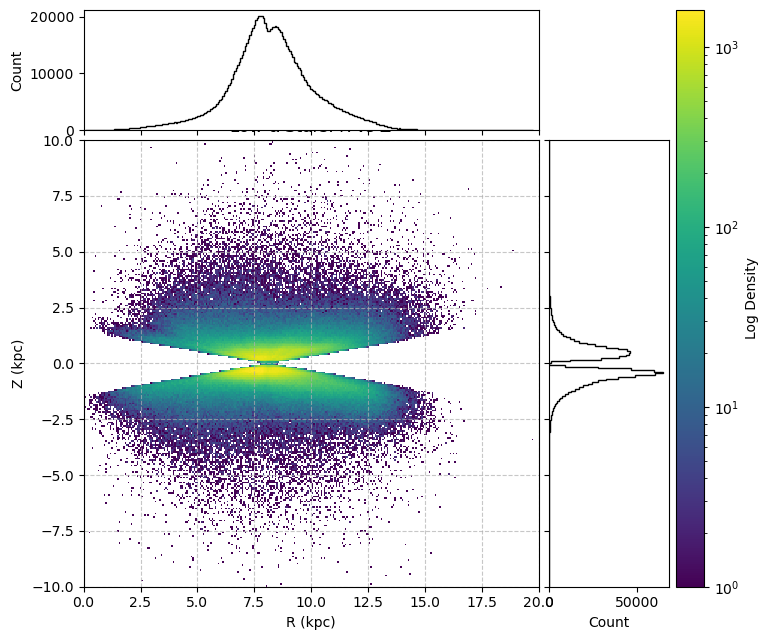

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def define_alpha_sequences(df, alpha_col='aom_xp', feh_col='mh_xgboost'):
    alpha = df[alpha_col]
    feh = df[feh_col]

    # High-α
    high_alpha = (
        ((feh < -0.6) & (alpha > 0.28)) |
        ((feh >= -0.6) & (feh <= 0.125) & (alpha > (-0.25 * feh + 0.13))) |
        ((feh > 0.125) & (alpha > 0.1))
    )

    # Low-α
    low_alpha = (
        ((feh < -0.8) & (alpha < 0.21)) |
        ((feh >= -0.8) & (feh <= 0.07) & (alpha < (-0.21 * feh + 0.045))) |
        ((feh > 0.07) & (alpha < 0.03))
    )

    return df[high_alpha], df[low_alpha]

def plot_rz_distribution(df, title, r_column='R', z_column='Z', bins=300):
    R = df[r_column]
    Z = df[z_column]

    fig, ax_scatter = plt.subplots(figsize=(8, 6.5))
    divider = make_axes_locatable(ax_scatter)
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax_scatter)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax_scatter)

    h = ax_scatter.hist2d(R, Z, bins=bins, norm=LogNorm(), cmap="viridis", cmin=1)
    cbar = fig.colorbar(h[3], ax=ax_scatter, pad=0.01)
    cbar.set_label("Log Density")

    ax_scatter.set_xlabel("R (kpc)")
    ax_scatter.set_ylabel("Z (kpc)")
    ax_scatter.set_xlim(0, 20)
    ax_scatter.set_ylim(-10, 10)
    ax_scatter.set_title(title)
    ax_scatter.grid(True, linestyle="--", alpha=0.7)

    ax_histx.hist(R, bins=bins, histtype="step", color="black")
    ax_histy.hist(Z, bins=bins, histtype="step", orientation="horizontal", color="black")
    ax_histx.tick_params(labelbottom=False)
    ax_histy.tick_params(labelleft=False)
    ax_histx.set_ylabel("Count")
    ax_histy.set_xlabel("Count")

    fig.tight_layout()
    plt.show()

# Example usage
# df = pd.read_csv('your_dataset.csv')  # Load your full DataFrame first
df_high, df_low = define_alpha_sequences(df_vis)

plot_rz_distribution(df_high, title="High-α Stars: R vs Z")
plot_rz_distribution(df_low, title="Low-α Stars: R vs Z")


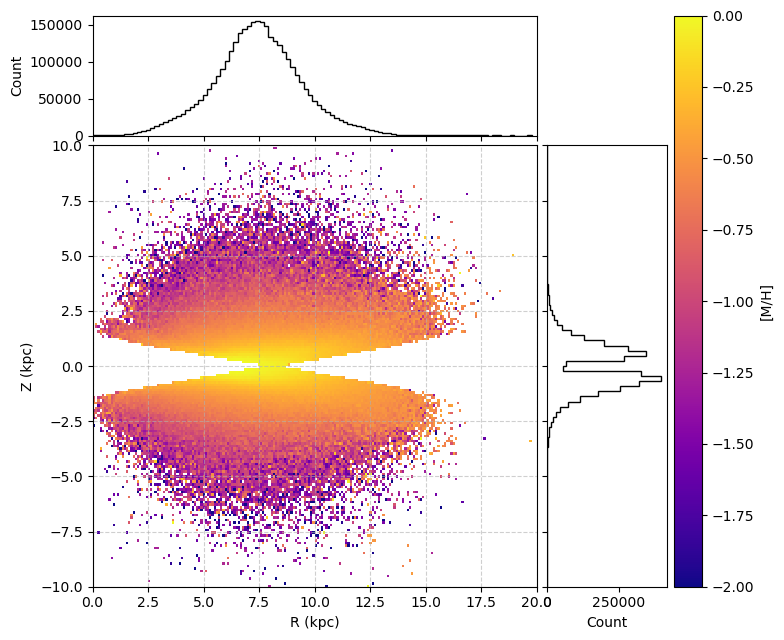

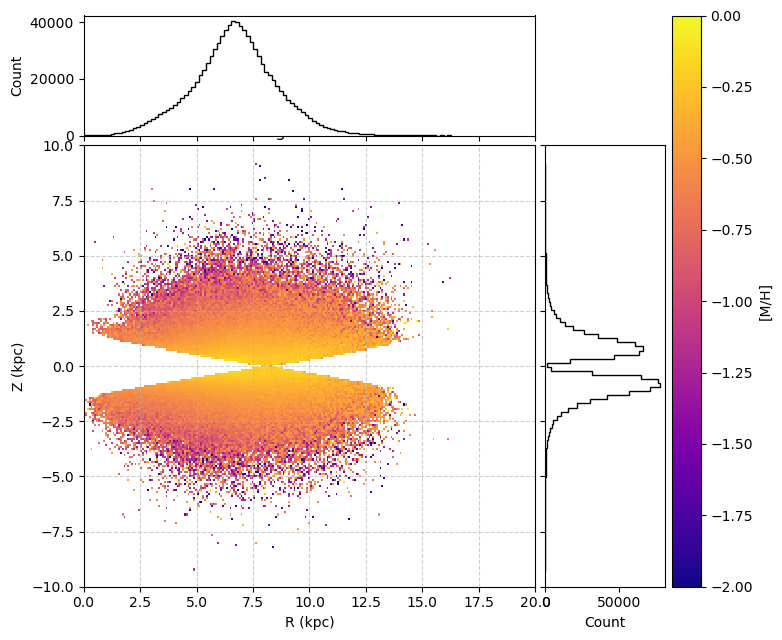

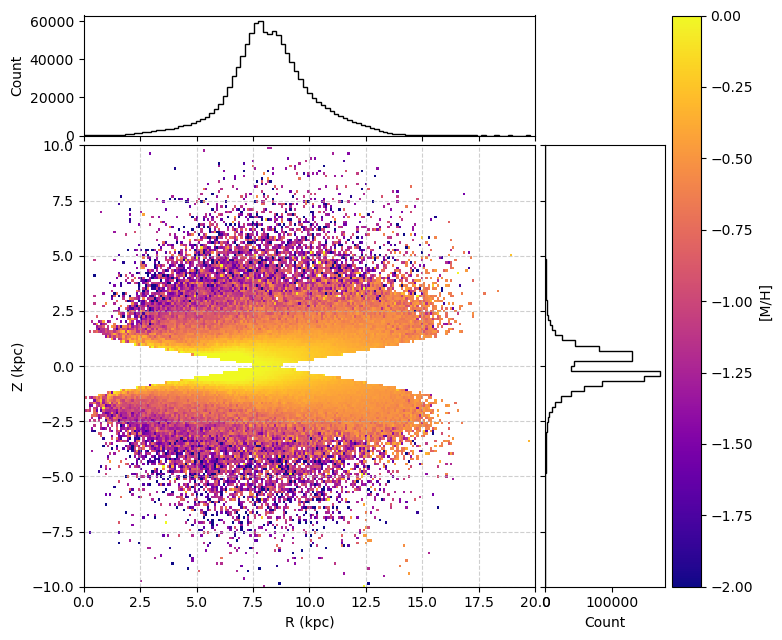

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic_2d
from mpl_toolkits.axes_grid1 import make_axes_locatable

def define_alpha_sequences(df, alpha_col='aom_xp', feh_col='mh_xgboost'):
    alpha = df[alpha_col]
    feh = df[feh_col]

    # High-α selection
    high_alpha = (
        ((feh < -0.6) & (alpha > 0.28)) |
        ((feh >= -0.6) & (feh <= 0.125) & (alpha > (-0.25 * feh + 0.13))) |
        ((feh > 0.125) & (alpha > 0.1))
    )

    # Low-α selection
    low_alpha = (
        ((feh < -0.8) & (alpha < 0.21)) |
        ((feh >= -0.8) & (feh <= 0.07) & (alpha < (-0.21 * feh + 0.045))) |
        ((feh > 0.07) & (alpha < 0.03))
    )

    return df[high_alpha], df[low_alpha]

def plot_rz_metallicity(df, title, output_file, r_col='R', z_col='Z', feh_col='mh_xgboost', bins=200, vmin=-2, vmax=0.):
    R = df[r_col]
    Z = df[z_col]
    feh = df[feh_col]

    # Clean NaNs
    mask = np.isfinite(R) & np.isfinite(Z) & np.isfinite(feh)
    R, Z, feh = R[mask], Z[mask], feh[mask]

    # 2D binned statistic: mean metallicity
    stat, x_edge, y_edge, _ = binned_statistic_2d(R, Z, feh, statistic='mean', bins=bins)

    X, Y = np.meshgrid(
        0.5 * (x_edge[:-1] + x_edge[1:]),
        0.5 * (y_edge[:-1] + y_edge[1:])
    )

    # Main plot with 1D histograms
    fig, ax_main = plt.subplots(figsize=(8, 6.5))
    divider = make_axes_locatable(ax_main)
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax_main)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax_main)

    # R-Z color-coded by mean [M/H]
    im = ax_main.pcolormesh(X, Y, stat.T, shading='auto', cmap='plasma', vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, ax=ax_main, pad=0.01)
    cbar.set_label('[M/H]')

    # Axes limits
    ax_main.set_xlim(0, 20)
    ax_main.set_ylim(-10, 10)
    ax_main.set_xlabel('R (kpc)')
    ax_main.set_ylabel('Z (kpc)')
    ax_main.set_title(title)
    ax_main.grid(True, linestyle='--', alpha=0.6)

    # 1D histograms
    ax_histx.hist(R, bins=100, histtype='step', color='black')
    ax_histy.hist(Z, bins=100, histtype='step', orientation='horizontal', color='black')

    # Hide tick labels on histograms
    ax_histx.tick_params(labelbottom=False)
    ax_histy.tick_params(labelleft=False)

    ax_histx.set_ylabel("Count")
    ax_histy.set_xlabel("Count")

    fig.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

# Usage
df_high, df_low = define_alpha_sequences(df_vis)

plot_rz_metallicity(df_vis, "All Stars", "../figures/vis_rz_metallicity_all.png")
plot_rz_metallicity(df_high, "High-α Stars", "../figures/vis_rz_metallicity_high_alpha.png")
plot_rz_metallicity(df_low, "Low-α Stars", "../figures/vis_rz_metallicity_low_alpha.png")


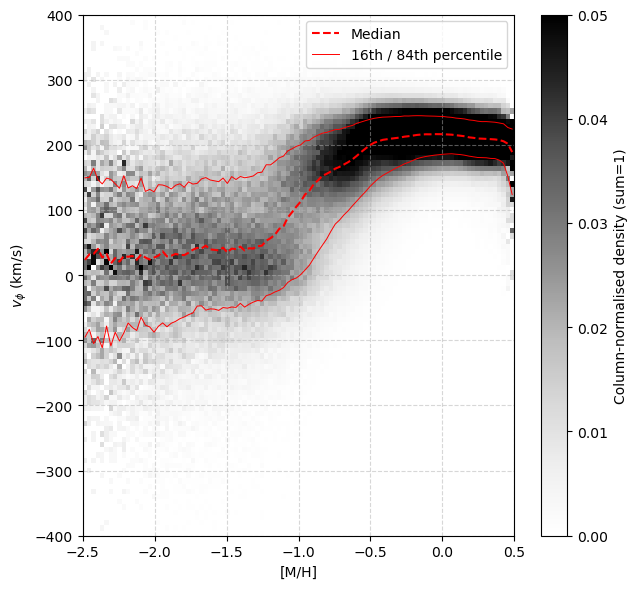

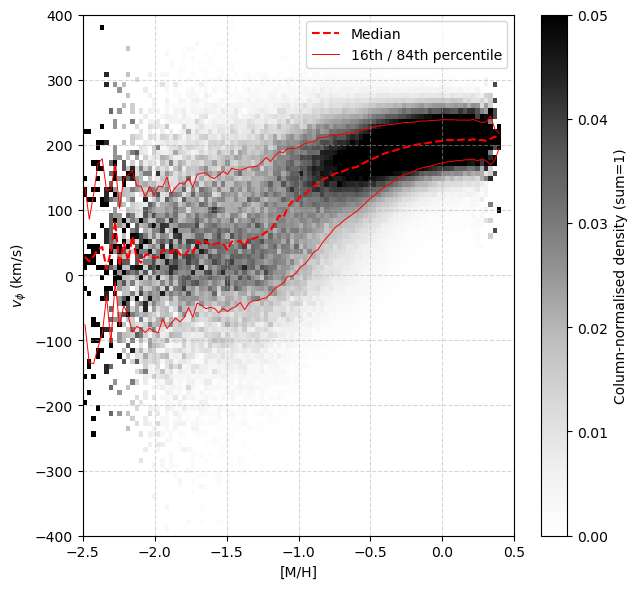

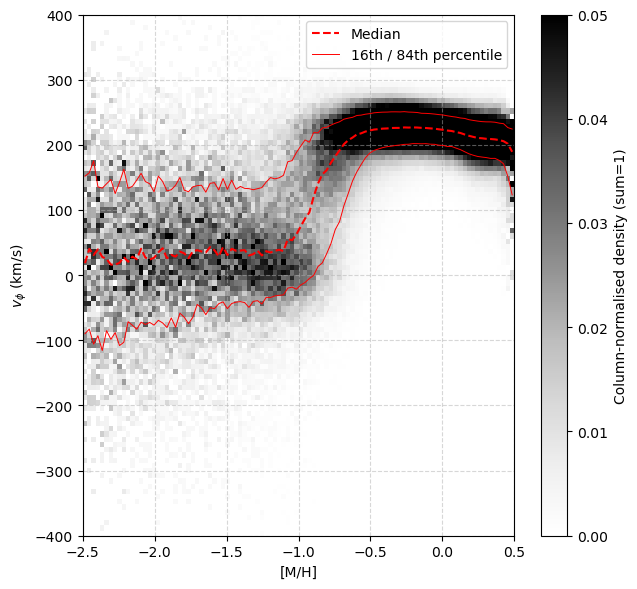

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic
from matplotlib.colors import Normalize

# Bin setup
num_bins = 100
mh_bins = np.linspace(-2.5, 0.5, num_bins + 1)
vphi_bins = np.linspace(-400, 400, num_bins + 1)
mh_centers = 0.5 * (mh_bins[:-1] + mh_bins[1:])

def plot_hist_column_normalised(df, title, filename):
    # Drop missing values
    df = df.dropna(subset=['mh_xgboost', 'v_phi'])

    # Extract values
    mh = df['mh_xgboost'].values
    vphi = df['v_phi'].values

    # Compute 2D histogram
    hist, _, _ = np.histogram2d(mh, vphi, bins=[mh_bins, vphi_bins])

    # Column-normalise by sum (not max)
    with np.errstate(invalid='ignore'):
        hist_colsum_norm = hist / np.sum(hist, axis=1, keepdims=True)
    hist_colsum_norm[np.isnan(hist_colsum_norm)] = 0  # replace NaNs

    # Running statistics
    medians, _, _ = binned_statistic(mh, vphi, statistic='median', bins=mh_bins)
    p16, _, _ = binned_statistic(mh, vphi, statistic=lambda x: np.percentile(x, 16), bins=mh_bins)
    p84, _, _ = binned_statistic(mh, vphi, statistic=lambda x: np.percentile(x, 84), bins=mh_bins)

    # Plot
    plt.figure(figsize=(6.5, 6))
    plt.pcolormesh(mh_bins, vphi_bins, hist_colsum_norm.T, cmap='Greys', norm=Normalize(vmin=0, vmax=0.05)) #hist_colsum_norm.max()
    plt.plot(mh_centers, medians, linestyle='--', label='Median',color='red')
    plt.plot(mh_centers, p16, linestyle='-', linewidth=0.7, label='16th / 84th percentile',color='red')
    plt.plot(mh_centers, p84, linestyle='-', linewidth=0.7,color='red')
    
    plt.xlabel('[M/H]')
    plt.ylabel(r'$v_\phi$ (km/s)')
    #plt.title(title)
    plt.ylim(-400, 400)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.colorbar(label='Column-normalised density (sum=1)')
    plt.tight_layout()
    plt.savefig(f'../figures/{filename}', dpi=300)
    plt.show()

# Plot for each group
plot_hist_column_normalised(df_vis, 'All Stars: [M/H] vs $v_\\phi$', 'vis_mh_vphi_all.png')
plot_hist_column_normalised(df_high, 'High-α Stars: [M/H] vs $v_\\phi$', 'vis_mh_vphi_high_alpha.png')
plot_hist_column_normalised(df_low, 'Low-α Stars: [M/H] vs $v_\\phi$', 'vis_mh_vphi_low_alpha.png')
